# 1-7. 프로젝트: 가위바위보 분류기 만들기   
   
* training set(총 2341장): 김윤경님 + 강종구(2차) + 이영빈님(2차) + 홍진표님(2차) + 이영빈님(3차) 
* test set(총 300장): 홍진표님(1차) 
* epochs: 10

첫 번째 Exploration Stage에서는 가위바위보 분류기를 만들었다.

실습에서 해본 0~9 숫자 분류 모델의 input_shape 중 3번째 파라미터를 흑백(1)을 RGB(3)로 변경했다. 마지막 Dense의 첫 파라미터가 최종 분류기의 클래스 수임을 알게 되어 3(가위, 바위, 보)으로 변경했다. 아직 Sequential Model의 내용을 정확히 이해할 수는 없지만, 파라미터 값을 바꿀 때마다 accuracy가 달라짐을 확인했다.   
   
트레이닝 시에는 영향을 끼치는 몇 가지 요인이 있었다. 첫째, 데이터가 되는 손 사진을 말끔한 벽을 뒤에 두고 찍어 손과 배경이 명확히 구분되도록 하면 정확도가 올라갔다. 둘째, 조원들의 사진과 슬랙에 공유된 사진을 모아 training data의 양이 많아질수록 정확도가 올라갔다. 테스트 데이터 역시 트레이닝 데이터와 비슷한 환경에서 찍힌 것이어야 모델이 인식을 잘 하는 것으로 보인다.

---

<테스트 결과>
* 1차 테스트
```
10/10 - 2s - loss: 2.7910 - accuracy: 0.6900
test_loss: 2.790980339050293 
test_accuracy: 0.6899999976158142
```
* 2차 테스트
```
10/10 - 2s - loss: 2.2659 - accuracy: 0.6667
test_loss: 2.265941619873047 
test_accuracy: 0.6666666865348816
```

In [1]:
# initialize
import numpy as np

training_filetype = "JPEG"
training_endswith = ".jpg"

test_filetype = "JPEG"
test_endswith = ".jpg"

## 데이터를 준비하자

### 데이터 불러오기 + resize 하기

In [2]:
# PIL 라이브러리가 설치되어 있지 않다면 설치
!pip install pillow

from PIL import Image
import os, glob

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [ ]:
# 이미지 크기 변환 (이미 되어있으므로 생략)
'''
img_dirs = [{'name': "scissor", 'path': "/aiffel/rock_scissor_paper/scissor"},
        {'name': "rock", 'path': "/aiffel/rock_scissor_paper/rock"},
        {'name': "paper", 'path': "/aiffel/rock_scissor_paper/paper"}]

for img_dir in img_dirs:
    print("현재 이미지 종류: " + img_dir['name'])
    curr_path = os.getenv("HOME") + img_dir['path']
    print(">> 이미지 디렉토리 경로: ", img_dir['path'])

    images = glob.glob(curr_path + "/*" + training_endswith)
    
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, training_filetype)
    
    print("* resize completed: " + img_dir['name'] + " (" str(len(images)) + ")")
'''

In [3]:
def load_training_data(img_path, file_endswith):
    # 가위: 0 / 바위: 1 / 보: 2
    number_of_data = 2341
    img_size = 28
    color = 3
    
    # 이미지 데이터와 라벨 데이터를 담을 행렬(matrix) 영역 생성
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)
    
    idx = 0
    for file in glob.iglob(img_path + '/scissor/*' + file_endswith):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 가위 : 0
        idx = idx + 1
        
    for file in glob.iglob(img_path + '/rock/*' + file_endswith):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 바위 : 1
        idx = idx + 1
        
    for file in glob.iglob(img_path + '/paper/*' + file_endswith):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 보 : 2
        idx = idx + 1
        
    print("학습데이터(x_train)의 이미지 개수는", idx, "입니다.")
    return imgs, labels

image_dir_path_training = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train_retake_combined"
(x_train, y_train)=load_training_data(image_dir_path_training, training_endswith)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 2341 입니다.
x_train shape: (2341, 28, 28, 3)
y_train shape: (2341,)


라벨:  0


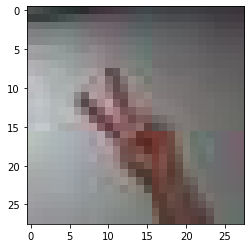

In [4]:
# 이미지 불러졌는지 확인
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 딥러닝 네트워크 설계하기

In [5]:
import tensorflow as tf
from tensorflow import keras
# import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                12816     
_________________________________________________________________
dense_1 (Dense)              (No

### 딥러닝 네트워크 학습시키기

In [6]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10)

Epoch 1/10
74/74 [==============================] - 4s 51ms/step - loss: 2.4004 - accuracy: 0.4648
Epoch 2/10
74/74 [==============================] - 0s 1ms/step - loss: 0.6749 - accuracy: 0.7206
Epoch 3/10
74/74 [==============================] - 0s 1ms/step - loss: 0.4855 - accuracy: 0.8120
Epoch 4/10
74/74 [==============================] - 0s 1ms/step - loss: 0.3580 - accuracy: 0.8676
Epoch 5/10
74/74 [==============================] - 0s 1ms/step - loss: 0.2615 - accuracy: 0.9052
Epoch 6/10
74/74 [==============================] - 0s 1ms/step - loss: 0.2423 - accuracy: 0.9158
Epoch 7/10
74/74 [==============================] - 0s 1ms/step - loss: 0.1807 - accuracy: 0.9398
Epoch 8/10
74/74 [==============================] - 0s 1ms/step - loss: 0.1523 - accuracy: 0.9522
Epoch 9/10
74/74 [==============================] - 0s 1ms/step - loss: 0.1324 - accuracy: 0.9569
Epoch 10/10
74/74 [==============================] - 0s 1ms/step - loss: 0.1074 - accuracy: 0.9688


### 얼마나 잘 만들었는지 확인하기 (테스트)

In [ ]:
# 이미지 크기 변환 (이미 되어있으므로 생략)
'''
img_dirs = [{'name': "scissor", 'path': "/aiffel/rock_scissor_paper/test/scissor"},
        {'name': "rock", 'path': "/aiffel/rock_scissor_paper/test/rock"},
        {'name': "paper", 'path': "/aiffel/rock_scissor_paper/test/paper"}]

for img_dir in img_dirs:
    print("현재 이미지 종류: " + img_dir['name'])
    curr_path = os.getenv("HOME") + img_dir['path']
    print(">> 이미지 디렉토리 경로: ", img_dir['path'])

    images = glob.glob(curr_path + "/*" + test_endswith)
    
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, test_filetype)
    
    print("* resize completed: " + img_dir['name'])
'''

In [7]:
def load_test_data(img_path, file_endswith):
    number_of_data = 300
    img_size = 28
    color = 3
    
    # 이미지 데이터와 라벨 데이터를 담을 행렬(matrix) 영역 생성
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)
    
    idx = 0
    for file in glob.iglob(img_path + '/scissor/*' + file_endswith):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 가위 : 0
        idx = idx + 1
        
    for file in glob.iglob(img_path + '/rock/*' + file_endswith):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 바위 : 1
        idx = idx + 1
        
    for file in glob.iglob(img_path + '/paper/*' + file_endswith):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 보 : 2
        idx = idx + 1
        
    print("학습데이터(x_train)의 이미지 개수는", idx, "입니다.")
    return imgs, labels

image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissor_paper/jp1"
(x_test, y_test)=load_test_data(image_dir_path_test, test_endswith)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [8]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 2s - loss: 2.2659 - accuracy: 0.6667
test_loss: 2.265941619873047 
test_accuracy: 0.6666666865348816
